In [14]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import curve_fit
import seaborn as sns
import time
import ROOT
import uproot4 as upr

In [2]:
sys.path.append('/storage/gpfs_data/neutrino/users/gi/sand-reco/tests/python_tools')
from NLLtreeoutReader import Reader, ROOT_tools, Reader_production
from Helix import Helix
from EventDisplay import EventDisplay
from dg_wire import dg_wire
from Circle import Circle
from Line2D import Line2D
tool = ROOT_tools()

In [3]:
test_file = "/storage/gpfs_data/neutrino/users/gi/sand-reco/tests/test_reconstruct_NLLmethod_smear.root"
edep_file = '/storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.0.edep-sim.root'

In [5]:
reader = Reader(test_file, "tReco")

FileNotFoundError: file not found

    '/storage/gpfs_data/neutrino/users/gi/sand-reco/tests/test_reconstruct_NLLmethod_smear.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [5]:
event_number = 12

helix_true = reader.get_true_helix(event_number)
helix_reco = reader.get_reco_helix(event_number)

fit_xz = reader.get_fit_xz(event_number)
fit_zy = reader.get_fit_zy(event_number)

wires = reader.get_wire_info(event_number)
all_wires = pd.read_csv("/storage/gpfs_data/neutrino/users/gi/sand-reco/wireinfo.txt")

fitted_circle = Circle(fit_zy['value'].values[0], 
                       fit_zy['value'].values[1],
                       fit_zy['value'].values[2])

fitted_line = Line2D.from_mq(fit_xz['value'].values[0],
                             fit_xz['value'].values[1])

initial_guess_circle = Circle( fit_zy['initial_guess'].values[0], 
                               fit_zy['initial_guess'].values[1],
                               fit_zy['initial_guess'].values[2])
                               
initial_guess_line = Line2D.from_mq(fit_xz['initial_guess'].values[0],
                                    fit_xz['initial_guess'].values[1])

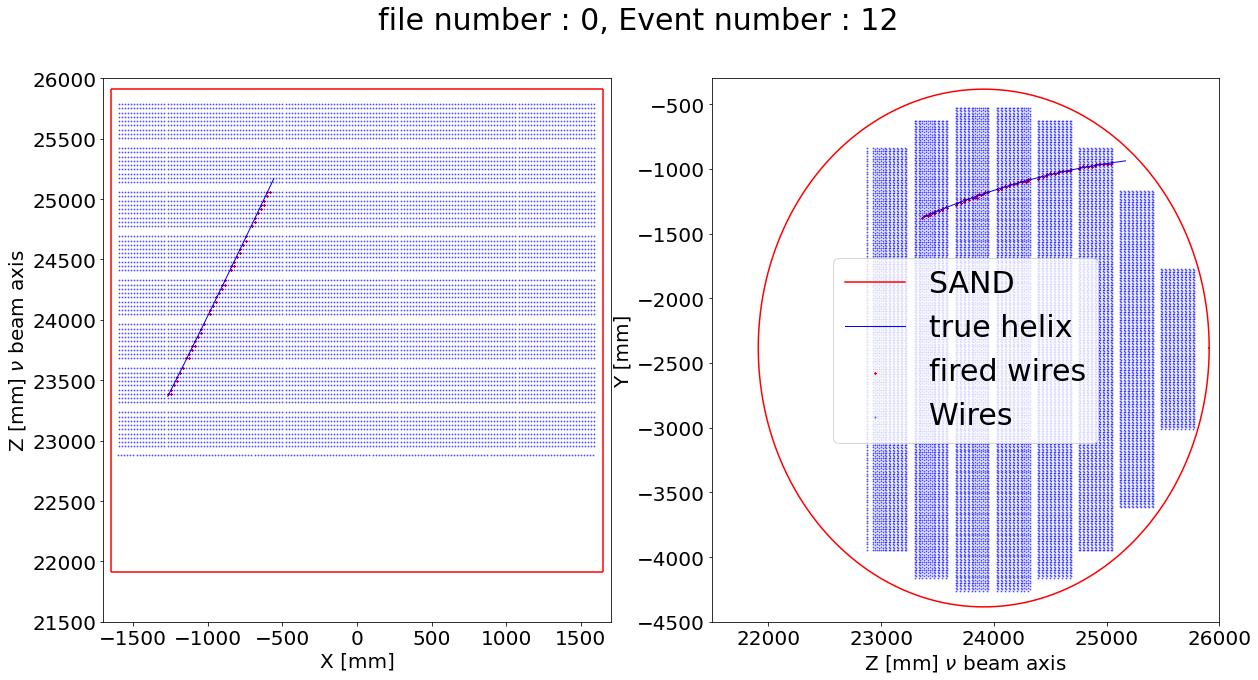

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

display1 = EventDisplay(arg_file_name = edep_file, 
                       arg_event_idx = event_number,
                       fig = fig,
                       ax_0 = ax[0], 
                       ax_1 = ax[1],
                       arg_fired_wires_info = wires)
display1.reset_zoom()
display1.plot_sand()

display1.plot_wires(color = 'red', label ='fired wires', alpha = 1, marker_size = 2)
display1.plot_wires_from_csv_table(all_wires, size = 1)

display1.plot_helix(helix_true, label = 'true helix', color = 'blue', linewidth = 1)

# display1.plot_line(line = initial_guess_line, label = 'initial guess', color = 'green')

display1.set_figure(labelsize=20, numbersize=20)

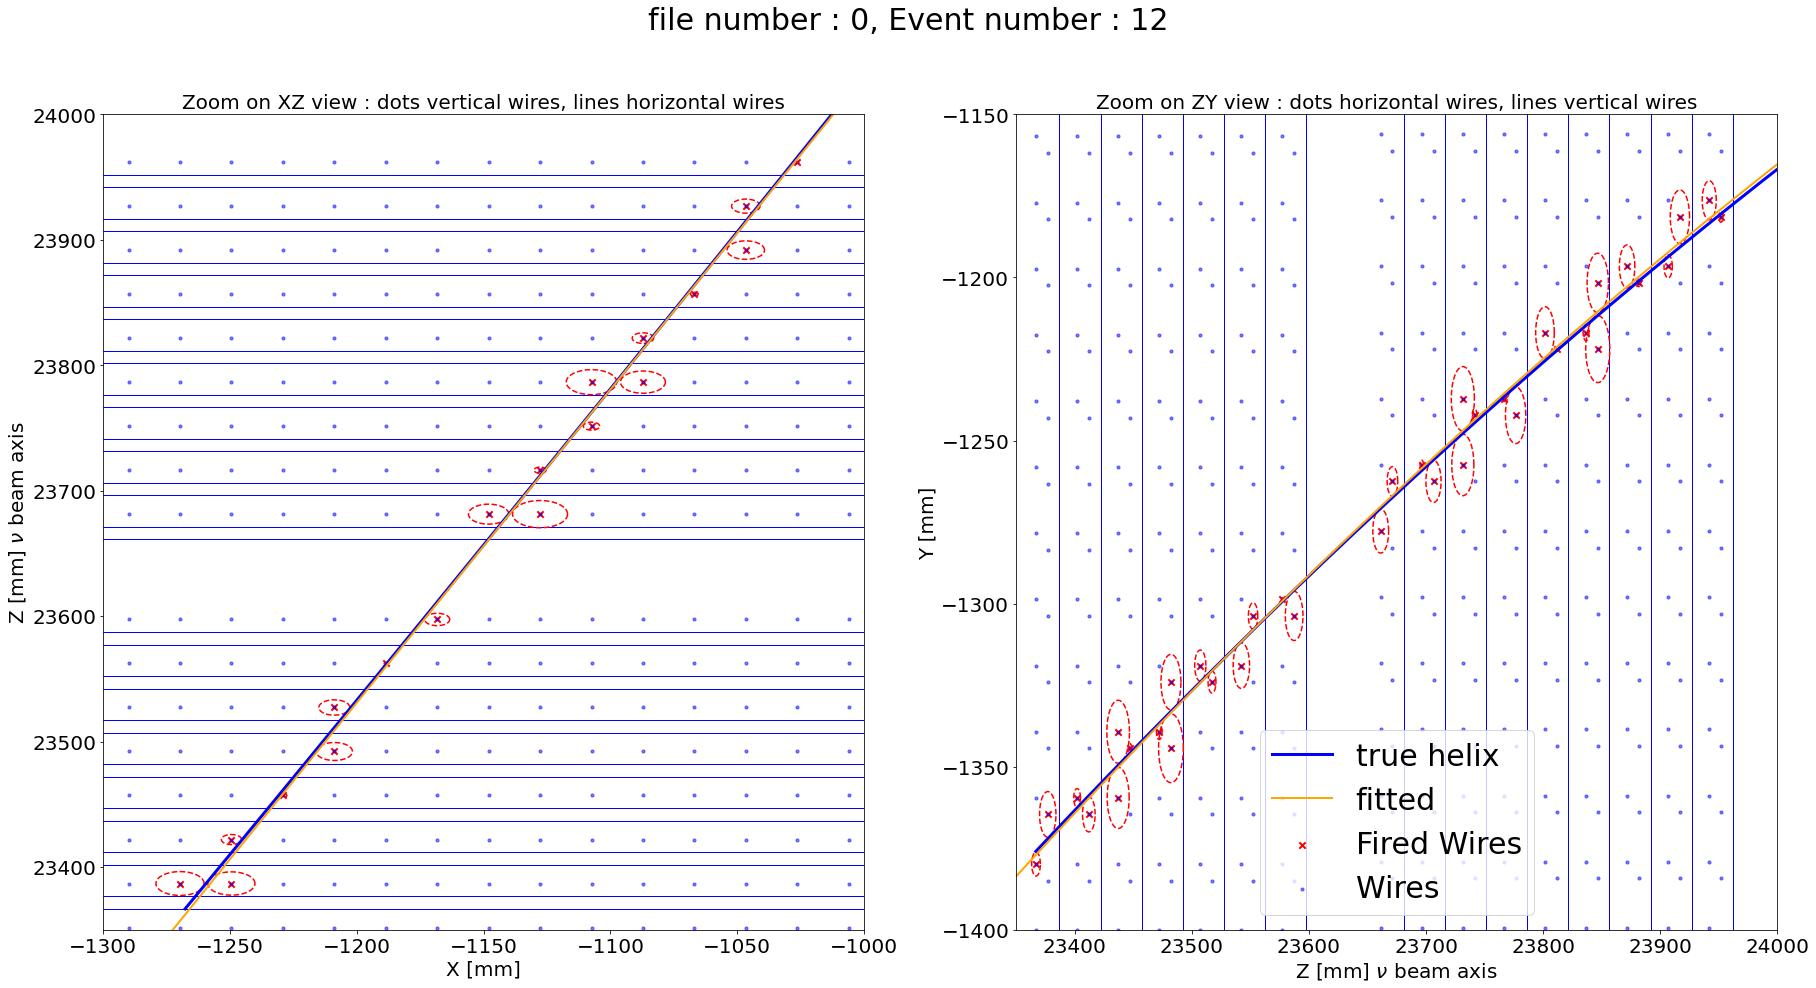

In [12]:
zoom_x = (-1300, -1000)
zoom_y = (-1400, -1150)
zoom_z = (23350, 24000)

fig, ax = plt.subplots(1, 2, figsize=(30, 15))

display3 = EventDisplay(arg_file_name = edep_file, 
                       arg_event_idx = event_number,
                       fig = fig,
                       ax_0 = ax[0], 
                       ax_1 = ax[1],
                       arg_fired_wires_info = wires)

display3.set_zoom(zoom_x, zoom_y, zoom_z)

# display3.plot_sand()
display3.plot_wires(plot_drift_circles=True,
                   plot_opposit_view=True,
                   add_assumed_signal_time_axis = False,
                   color='red',
                   label='Fired Wires',
                   alpha=1)

display3.plot_wires_from_csv_table(all_wires)

display3.plot_helix(helix_true, label = 'true helix', color = 'blue', linewidth = 3)

# display3.plot_line(line = initial_guess_line, label = 'initial guess', color = 'green')
# display3.plot_circle(circle = initial_guess_circle, label = 'intial guess', color = 'green')

display3.plot_line(line = fitted_line, label = 'fitted', color = 'orange', linewidth = 2, linestyle='solid')
display3.plot_circle(circle = fitted_circle, label = 'fitted', color = 'orange', linewidth = 2, linestyle='solid')

display3.set_figure(labelsize=20, numbersize=20)

ax[0].set_title("Zoom on XZ view : dots vertical wires, lines horizontal wires", fontsize = 20)
ax[1].set_title("Zoom on ZY view : dots horizontal wires, lines vertical wires", fontsize = 20)

plt.savefig("tests/plots/good_for_thesis/fitted_track_w_drift_circles.pdf")

In [7]:
wires.loc[wires['hor'] == True, 'x'] = wires['missing_coordinate']
wires.loc[wires['hor'] == False, 'y'] = wires['missing_coordinate']

Fake pattern reco check

In [3]:
from tDigitReader import tDigitReader

In [15]:
digit_file = "/storage/gpfs_data/neutrino/users/gi/sand-reco/tests/test_DigitizeDrift.root"
reco_file = "/storage/gpfs_data/neutrino/users/gi/sand-reco/tests/test_recoNLLmethod.root"

In [16]:
digit_reader = tDigitReader(digit_file, "tDigit")
reco_reader = Reader(reco_file, "tReco")

In [6]:
all_wires = pd.read_csv("/storage/gpfs_data/neutrino/users/gi/sand-reco/wireinfo.txt")

In [17]:
reco_reader.dataframe_wires.edep_event_index.unique()

array([  1,   5,   9,  19,  27,  33,  37,  44,  53,  59,  69,  75,  87,
        91,  98, 104, 111, 115, 122, 127, 131, 135, 139, 148, 152, 156,
       160, 166, 170, 175, 180, 189, 197, 206, 210, 214, 219, 226, 240,
       245, 250, 254, 260, 267, 276, 283, 288, 295, 299, 304, 310, 316,
       322, 331, 340, 346, 350, 358, 366, 370, 374, 379, 383, 393, 399,
       406, 414, 420, 428, 436, 445, 450, 460, 464, 468, 472, 477, 486,
       491, 501, 505, 509, 514, 519, 523, 528, 532, 537, 541, 546, 551,
       555, 560, 573, 577, 582, 595, 603, 610, 621, 626, 632, 640, 645,
       649, 656, 661, 666, 680, 689, 694, 699, 704, 709, 714, 718, 725,
       732, 746, 750, 756, 769, 779, 783, 788, 794, 798, 802, 806, 810,
       814, 825, 829, 833, 838, 844, 848, 854, 860, 866, 875, 880, 891,
       896, 915, 921, 927, 931, 935, 942, 948, 955, 963, 967, 973, 977,
       987, 991], dtype=uint32)

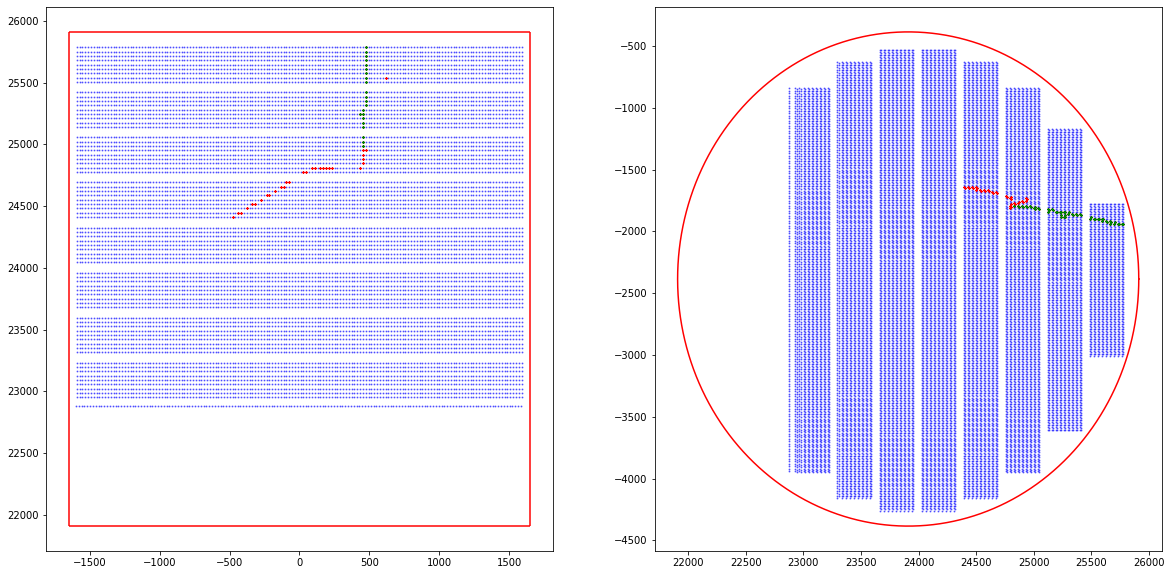

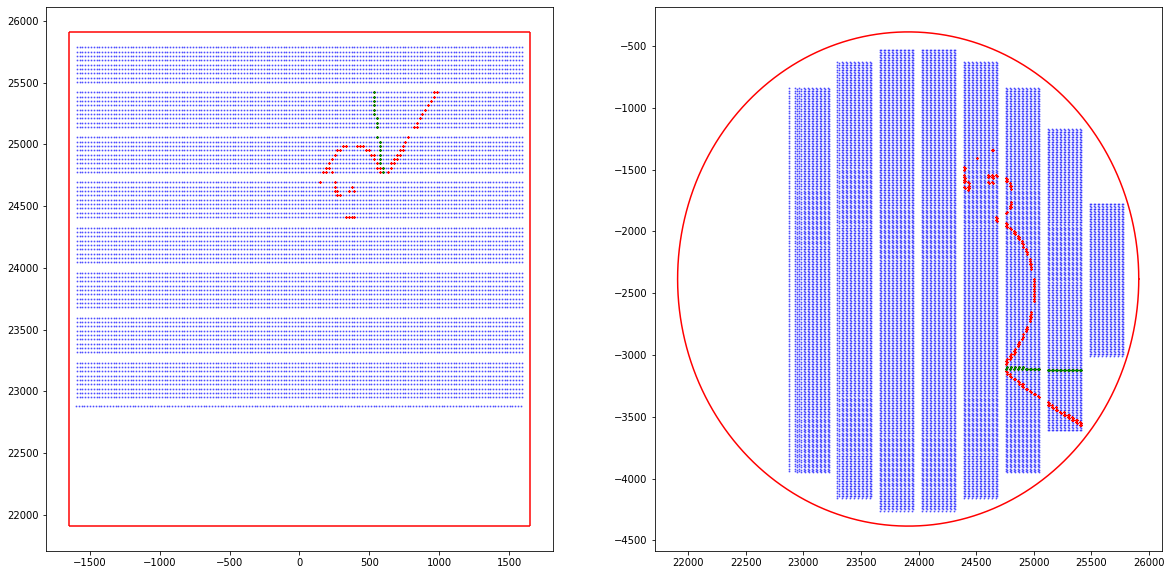

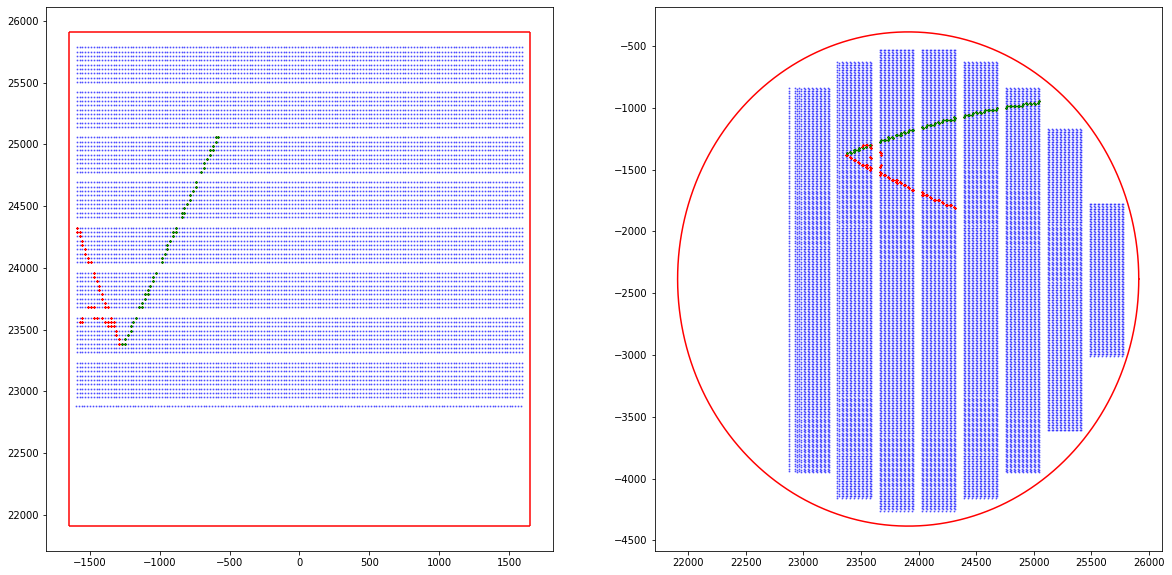

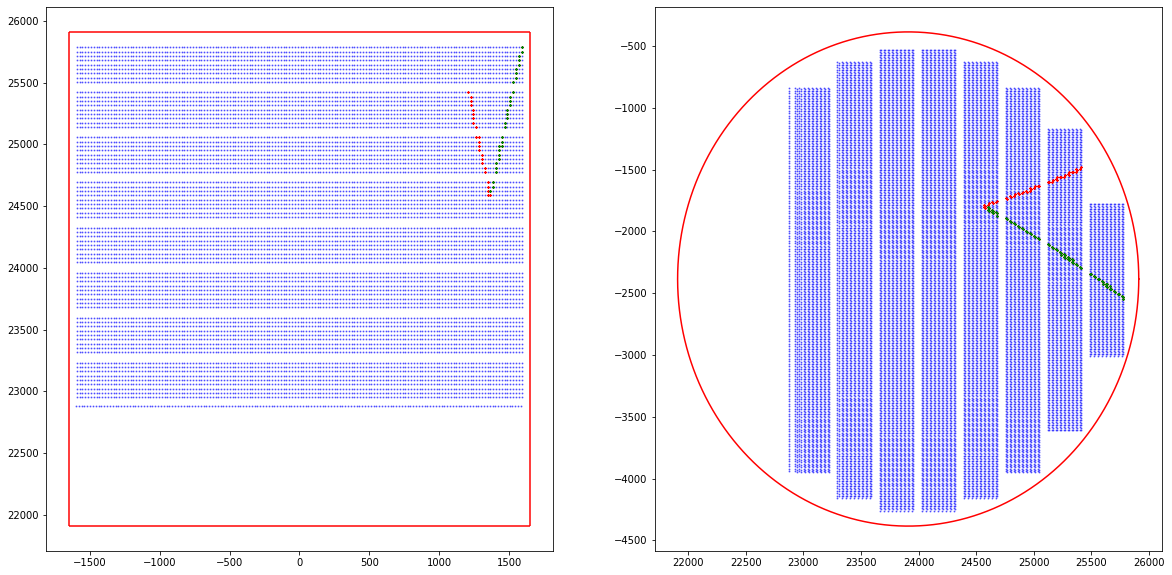

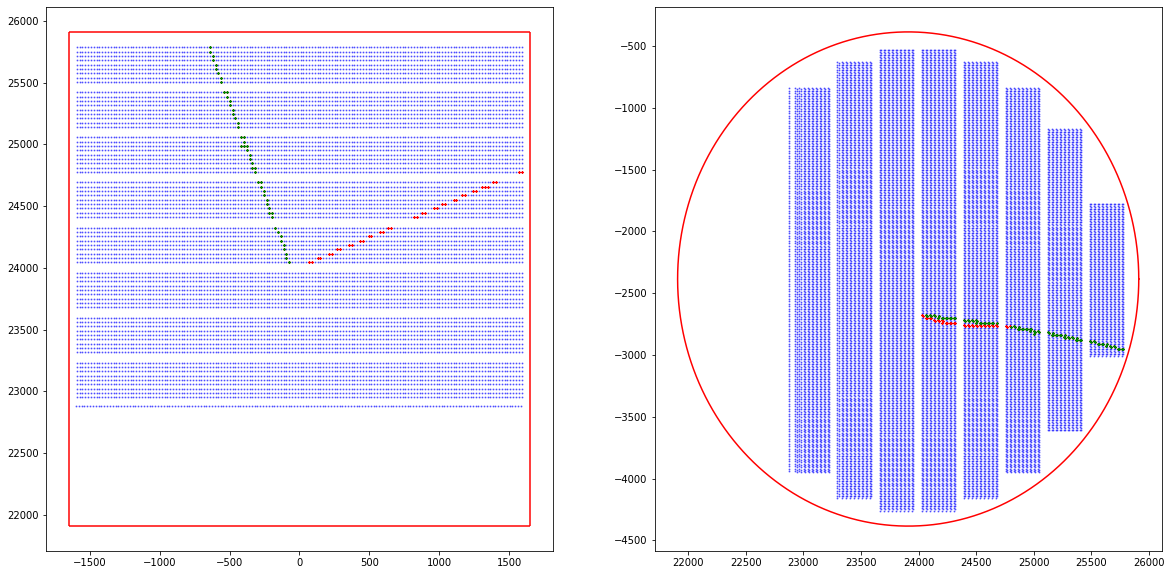

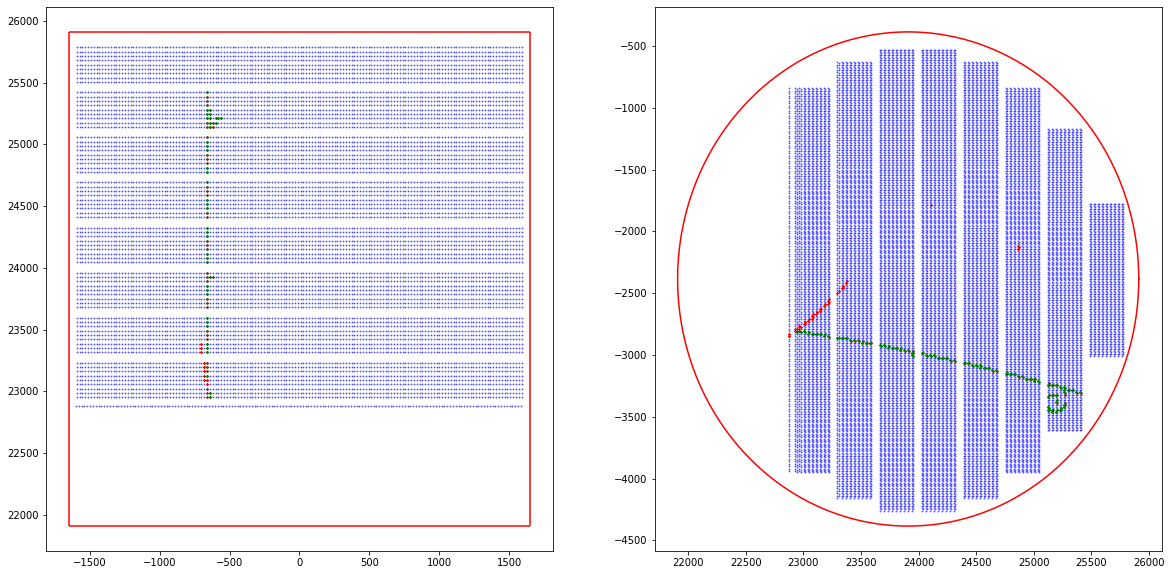

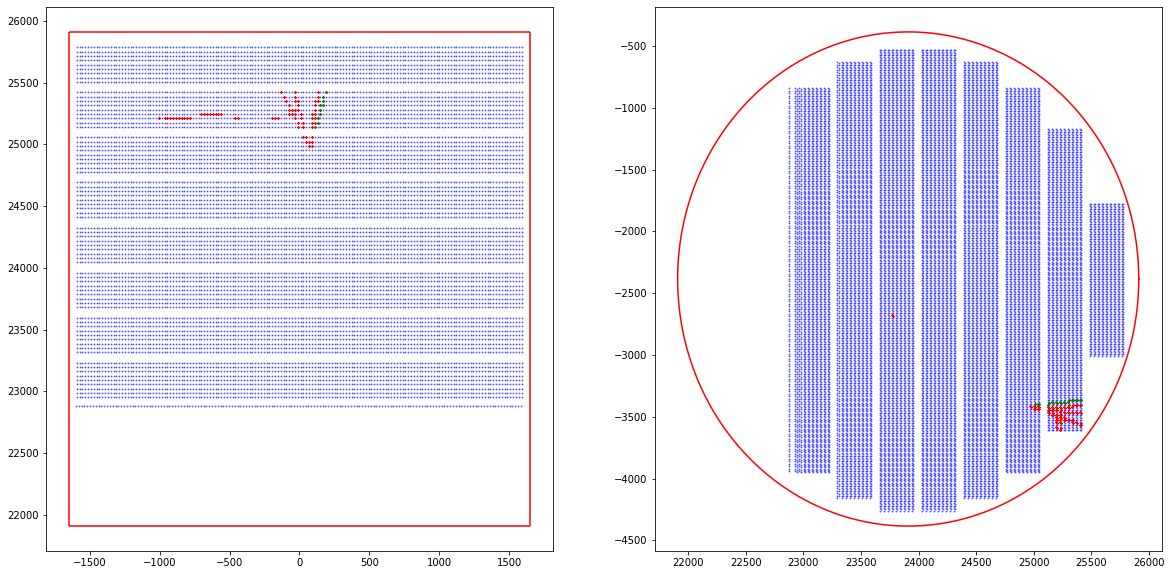

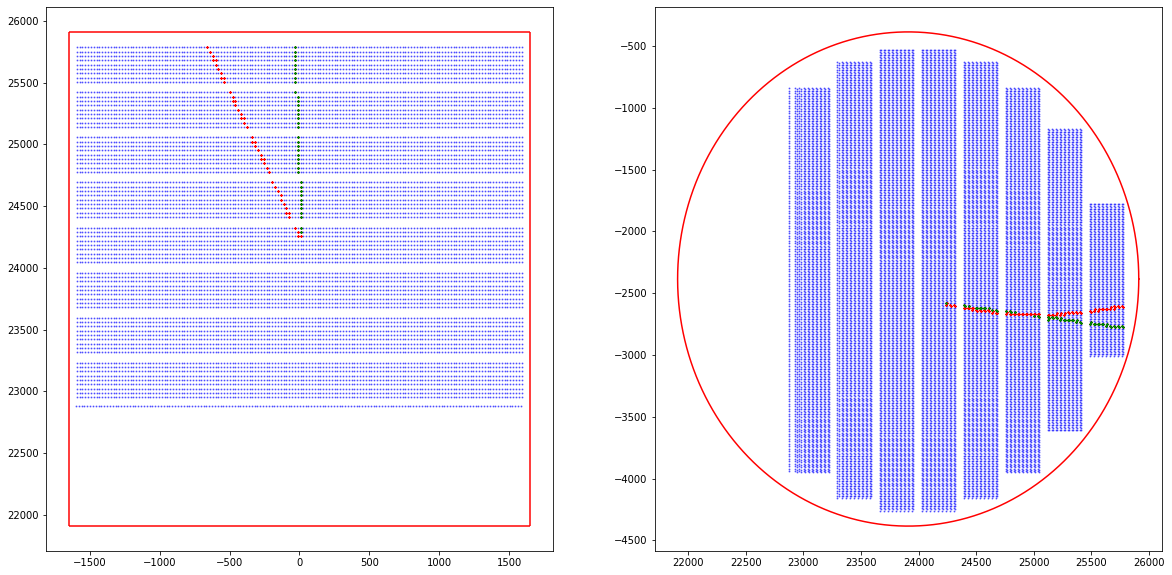

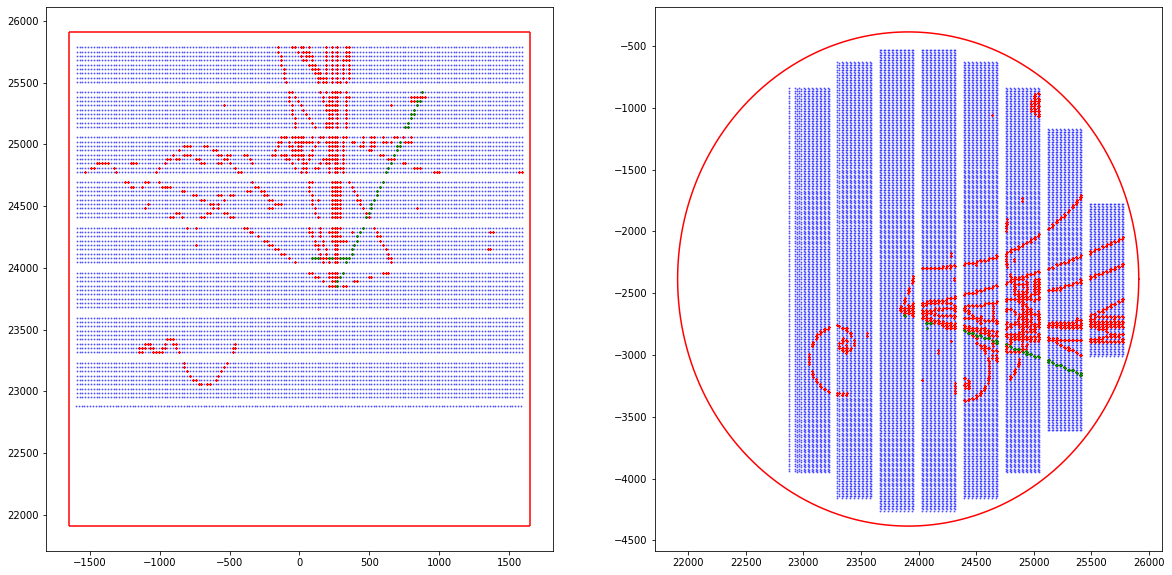

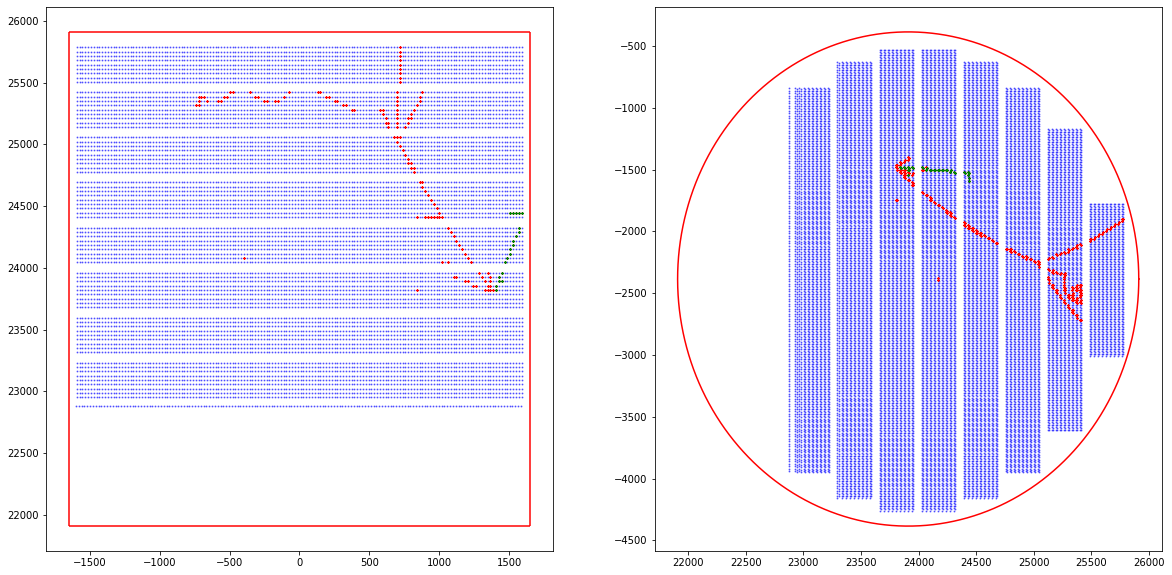

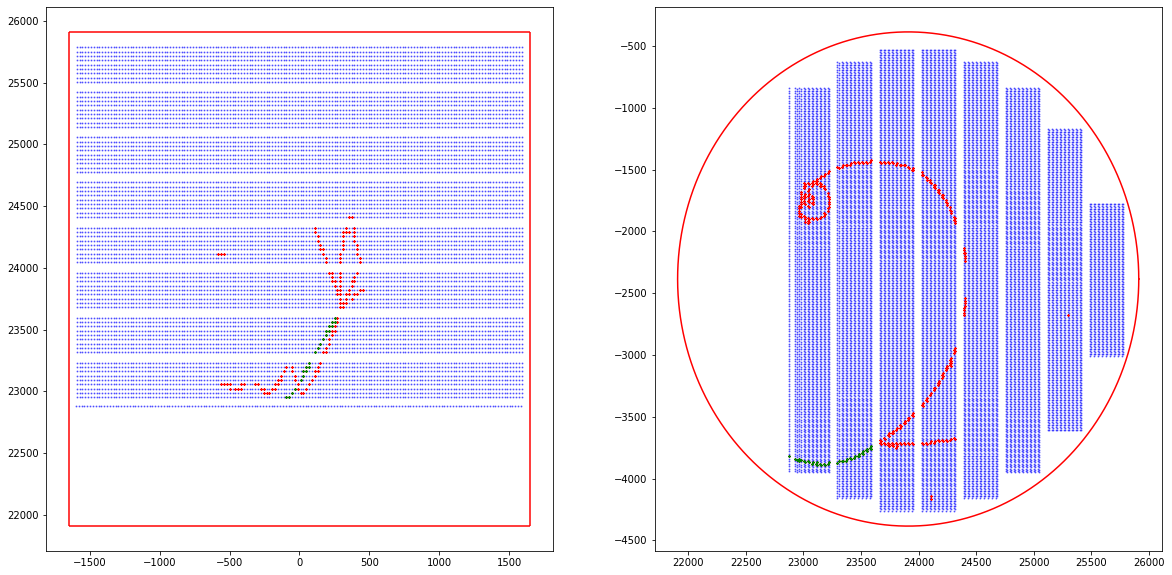

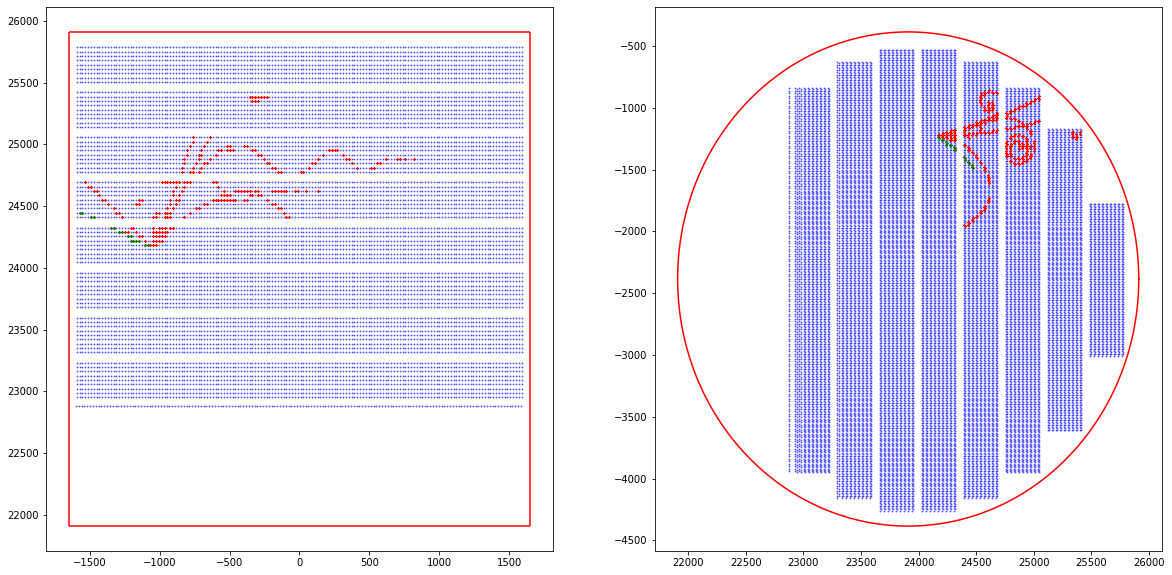

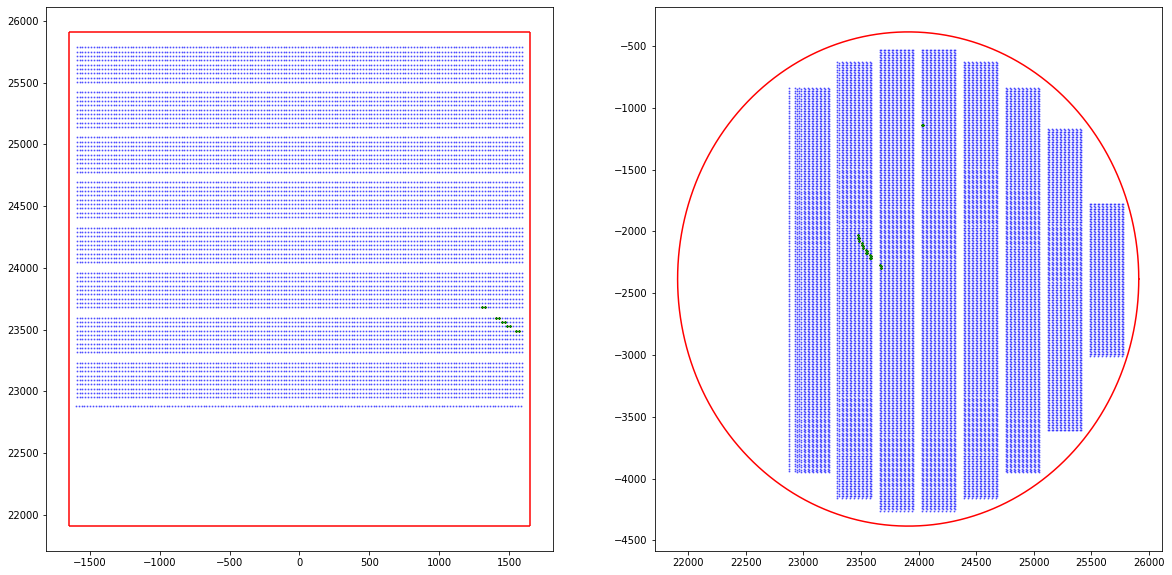

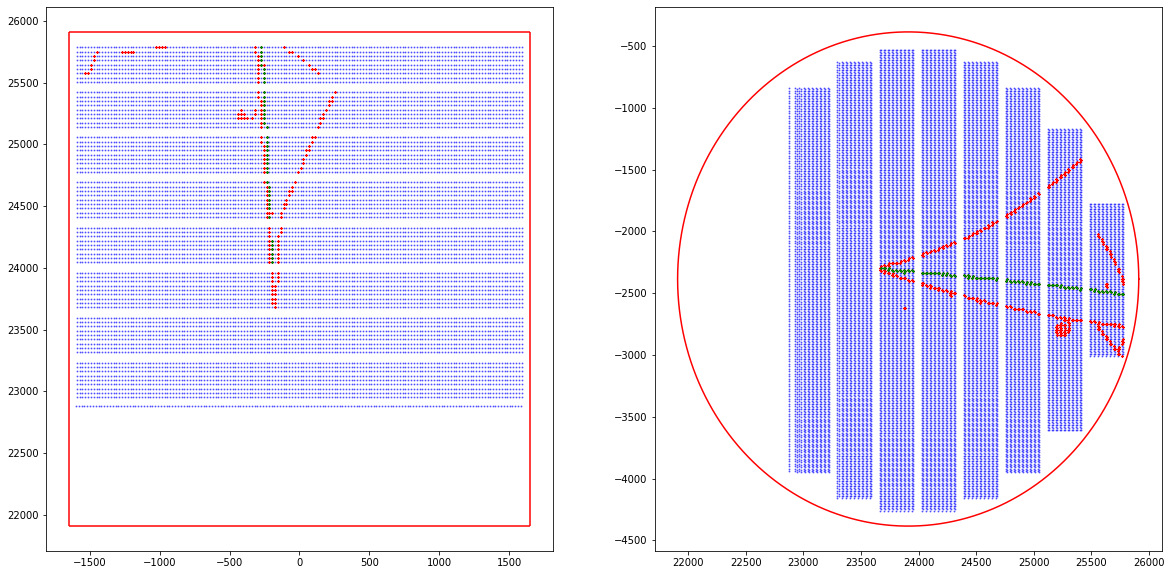

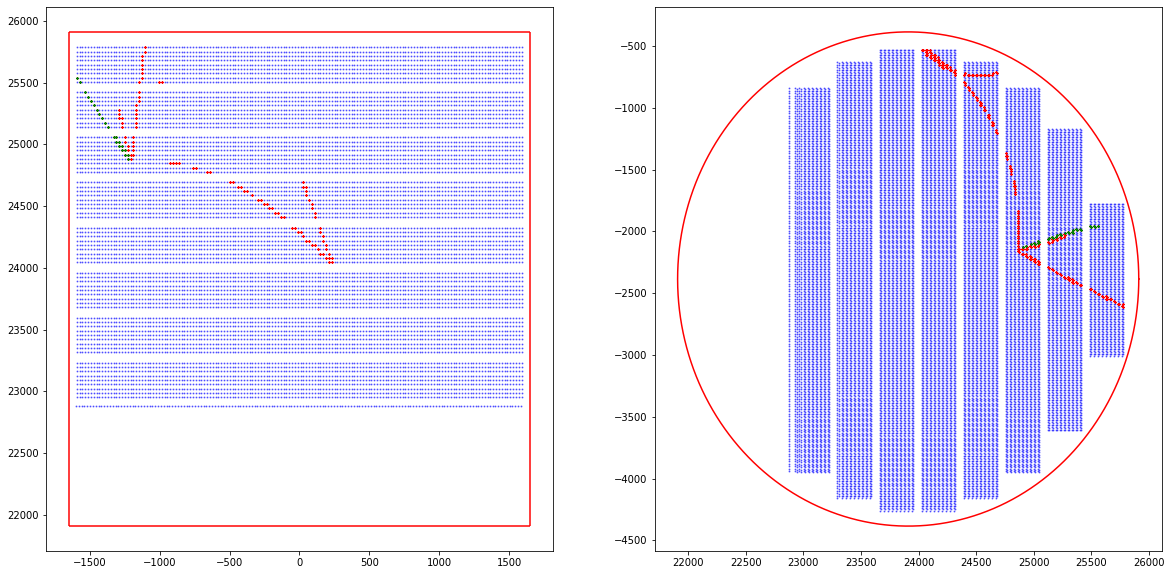

In [18]:
for edep_index in reco_reader.dataframe_wires.edep_event_index.unique()[:15]:
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    display1 = EventDisplay(arg_file_name = digit_file, 
                           arg_event_idx = edep_index,
                           fig = fig,
                           ax_0 = ax[0], 
                           ax_1 = ax[1],
                           arg_fired_wires_info = digit_reader.dataframe_wires)
    display2 = EventDisplay(arg_file_name = reco_file, 
                           arg_event_idx = edep_index,
                           fig = fig,
                           ax_0 = ax[0], 
                           ax_1 = ax[1],
                           arg_fired_wires_info = reco_reader.dataframe_wires)
    display1.reset_zoom()
    display1.plot_sand()

    display1.plot_wires_from_csv_table(all_wires, size = 1)

    display1.plot_wires(color = 'red', label ='fired wires', alpha = 1, marker_size = 2)
    display2.plot_wires(color = 'green', label ='fired wires', alpha = 1, marker_size = 2)